In [99]:
from langchain_openai import OpenAIEmbeddings
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langgraph.graph import START, END, StateGraph
from typing import List, TypedDict
from CONFIG import OPENAI_EMBEDDED_MODEL, GROQ_MODEL
from langchain_community.vectorstores import FAISS

In [100]:
load_dotenv()
llm = ChatGroq(model=GROQ_MODEL)
embedded_model = OpenAIEmbeddings(model=OPENAI_EMBEDDED_MODEL)

In [101]:
class state(TypedDict):
    question: str
    answer: str
    doc: List[str]

In [102]:
pdf_loading = PyPDFLoader(file_path='A:\AI_Projects_Practice\CRAG\The_Evolution_of_AI_in_Dubai.pdf')
pdf = pdf_loading.load()
len(pdf)

8

In [103]:
splitting = RecursiveCharacterTextSplitter(chunk_size=900, chunk_overlap=100).split_documents(pdf)
len(splitting)

24

In [104]:
vector_storage = FAISS.from_documents(splitting, embedded_model)

In [105]:
retrieved = vector_storage.as_retriever(search_type='similarity', search_kwargs={'k': 2})
for i in retrieved.invoke('dubai'):
    print(i.page_content)
    print('*'*100)

finance, and transportation. The strategic initiatives led by the Dubai government have propelled the
city to become a global hub for AI innovation. This evolution not only enhances operational
efficiencies but also positions Dubai as a leader in adopting advanced technologies.
Looking ahead, developers and businesses in Dubai should focus on these next steps for effective AI
integration:
Continuous Learning: Invest in upskilling teams through workshops and online courses on AI
technologies like machine learning and natural language processing.
Collaborate with Local Startups: Engage in partnerships with UAE-based startups to leverage
innovative AI solutions and integrate them into existing workflows.
Adopt Ethical AI Practices: Establish guidelines for ethical AI use to ensure transparency,
privacy, and fairness, enhancing public trust in AI applications.
****************************************************************************************************
Dubai AI Strategy: Introduced 

In [106]:
def retrieved_node(state):
    q = state['question']
    return {'doc': retrieved.invoke(q)}

In [112]:
prompt = ChatPromptTemplate(
    [
        ("system", "Answer only from the context. If not in context, say you don't know."),
        ("human", "Question is: {question}\n\nContext is: {context}")
    ]
)

def generate_node(state):
    context = "\n\n".join(d.page_content for d in state['doc'])
    question = state['question']
    out = (prompt|llm).invoke(
        {
            "question": question,
            "context": context
	  }
    )

    return {'answer':out.content}

In [113]:
graph = StateGraph(state)

graph.add_node('retrieved_node', retrieved_node)
graph.add_node('generate_node', generate_node)

graph.add_edge(START, 'retrieved_node')
graph.add_edge('retrieved_node', 'generate_node')
graph.add_edge('generate_node', END)

crag = graph.compile()

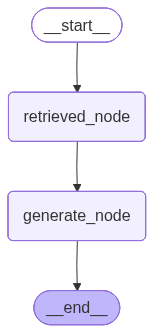

In [114]:
crag

In [124]:
output = crag.invoke(
    {
        'question': 'DUBAI',
        'doc': [],
        'answer': ''
    }
)

In [125]:
output['answer']

"In the context of finance and transportation, Dubai is being positioned as a global hub for AI innovation, with a focus on enhancing operational efficiencies and adopting advanced technologies. The Dubai government's strategic initiatives, such as the Dubai AI Strategy and Smart Dubai, aim to leverage AI to optimize government operations, improve city services, and advance economic development, including in the areas of finance and transportation."

In [126]:
for i in crag.invoke(
    {
        'question': 'DUBAI',
        'doc': [],
        'answer': ''
    }
)['doc']:
    print(i.page_content)
    print()
    print('=-'*50)
    print()

finance, and transportation. The strategic initiatives led by the Dubai government have propelled the
city to become a global hub for AI innovation. This evolution not only enhances operational
efficiencies but also positions Dubai as a leader in adopting advanced technologies.
Looking ahead, developers and businesses in Dubai should focus on these next steps for effective AI
integration:
Continuous Learning: Invest in upskilling teams through workshops and online courses on AI
technologies like machine learning and natural language processing.
Collaborate with Local Startups: Engage in partnerships with UAE-based startups to leverage
innovative AI solutions and integrate them into existing workflows.
Adopt Ethical AI Practices: Establish guidelines for ethical AI use to ensure transparency,
privacy, and fairness, enhancing public trust in AI applications.

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

Dubai AI Strategy: Introduce